# Data Cleaning and EDA for Housing Price Forecast

This notebook shows data cleaning process and EDA for a dataset I used in the housing price model. 
The main variables for the housing price forecasting model are housing price, number of listings from Realtor.com, and population net inflow data from USPS change of address dataset. 
Contents: 
1. Cleaning houding price dataset from Realtor.com 
2. Cleaning USPS Change of Address Data
3. Merging Realtor.com and USPS data
4. Descriptive Statistics
5. EDA 





In [1]:
import requests

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings

## 1. Realtor Data

I obtain data on home lisitng price, number of active listings, new listings, and numnber of days on a marketat a monthly frequency at the ZIP code from Realtor Data Center from July 2016 to December 2021. 

In [2]:
url = 'https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_Zip_History.csv'
realtor = pd.read_csv(url)
realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905956 entries, 0 to 1905955
Data columns (total 40 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   month_date_yyyymm                        int64  
 1   postal_code                              int64  
 2   postal_code.1                            int64  
 3   median_listing_price                     float64
 4   median_listing_price_mm                  float64
 5   median_listing_price_yy                  float64
 6   active_listing_count                     float64
 7   active_listing_count_mm                  float64
 8   active_listing_count_yy                  float64
 9   median_days_on_market                    float64
 10  median_days_on_market_mm                 float64
 11  median_days_on_market_yy                 float64
 12  new_listing_count                        float64
 13  new_listing_count_mm                     float64
 14  new_listing_count_

In [3]:
realtor.columns

Index(['month_date_yyyymm', 'postal_code', 'postal_code.1',
       'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total

For my hoousing price analysis, I use median_listing_price, active_listing_count, median_days_on_market. I drop other than these three indicators. 

In [4]:
# Drop columns which is out of my focus. 
realtor = realtor[['month_date_yyyymm', 'postal_code', 'median_listing_price', 'active_listing_count', 'median_days_on_market' ]]

# Drop duplicate
realtor.drop_duplicates(inplace=True)

realtor.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905956 entries, 0 to 1905955
Data columns (total 5 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   month_date_yyyymm      int64  
 1   postal_code            int64  
 2   median_listing_price   float64
 3   active_listing_count   float64
 4   median_days_on_market  float64
dtypes: float64(3), int64(2)
memory usage: 87.2 MB


I rename year-month-date column. And I newerly define year, month, date as well as yearmonth columns for future analysis.  

In [5]:
# rename month_date_yyyymm as date 
realtor_1 = realtor.rename(columns={'month_date_yyyymm': 'date'})

# Define year and month column
realtor_1['date'] = realtor_1['date'].astype(str)
realtor_1['year'] = realtor_1['date'].str[:4]
realtor_1['month'] = realtor_1['date'].str[4:]

# Define yearmonth column
cols = ['year', 'month']
realtor_1['yearmonth']= realtor_1[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

I change date to the datatime format, and set date and zipcode to index. 

In [6]:
# change 'date' to the datatime
realtor_1.date=pd.to_datetime(realtor_1.date, format='%Y%m')

# Set Multiindex (date and zips)
realtor_m = realtor_1.set_index(['postal_code', 'date']).sort_index() 

realtor_m.head()

median_listing_price  active_listing_count  \
postal_code date                                                     
1001        2016-07-01              209000.0                  60.0   
            2016-08-01              229900.0                  67.0   
            2016-09-01              219900.0                  65.0   
            2016-10-01              209900.0                  65.0   
            2016-11-01              209000.0                  59.0   

                        median_days_on_market  year month yearmonth  
postal_code date                                                     
1001        2016-07-01                   43.0  2016    07    201607  
            2016-08-01                   37.5  2016    08    201608  
            2016-09-01                   51.5  2016    09    201609  
            2016-10-01                   66.0  2016    10    201610  
            2016-11-01                   82.5  2016    11    201611

### Handling Missing values in housing data 

Number of missing values among total observations of 1,905,955. 

In [7]:
realtor_m.isnull().sum()

median_listing_price     3716
active_listing_count     3716
median_days_on_market       0
year                        0
month                       0
yearmonth                   0
dtype: int64

For 'median_listing_price', 'active_listing_count', I use interpolation to fill the misisng values. 

In [8]:
# using interpolate() to fill the missing values 

interpolate = ['median_listing_price', 'active_listing_count']

for x in interpolate:
    realtor_m[x] = realtor_m[x].interpolate()

realtor_m.isnull().sum()


median_listing_price     0
active_listing_count     0
median_days_on_market    0
year                     0
month                    0
yearmonth                0
dtype: int64

Now, all housing data is filled.   

# 2. Merge USPS Change of Address Data

## USPS migration data for each zipcode 

### USPS Change of Address Database (2018 - 2021)

The United States Postal Service’s National Change of Address (NCOA) dataset (https://about.usps.com/who/legal/foia/library.htm) has zip code-month level inflow and outflow data for all US zip codes since 2018. I can use this data to connect zip codes and city.  


In [ ]:
usps18 = pd.read_csv('Data/usps/Y2018.csv')
usps19 = pd.read_csv('Data/usps/Y2019.csv')
usps20 = pd.read_csv('Data/usps/Y2020.csv')
usps21 = pd.read_csv('Data/usps/Y2021.csv')

usps1819 = usps18.append(usps19, ignore_index=True)
usps181920 = usps1819.append(usps20, ignore_index=True)
usps = usps181920.append(usps21, ignore_index=True)
usps.info()


In [ ]:
usps.info()

In [ ]:
# Calcuate net inflow to the zipcode 

usps['netinflow'] = usps['TOTAL TO ZIP'] - usps['TOTAL FROM ZIP']

In [ ]:
# cleaning zipcode and rename it to zips 
usps.ZIPCODE = usps.ZIPCODE.map(lambda x:x.strip('=""'))
usps.rename({'ZIPCODE':'zips', 'YYYYMM':'yearmonth'}, axis=1, inplace=True)

In [ ]:
# Drop unnecessary columns
usps.drop(usps.iloc[:, 4:-1], inplace = True, axis = 1)
usps.info()

In [ ]:
usps.isnull().sum()

### Save as usps.csv 

In [ ]:
usps.to_csv('Data/usps.csv', index = False)

## 2. Merge USPS Change of Address Data to Realtor Housing Price Data
I use USPS's net population inflow data at each zipcode as measure of housing demand in an area. So I merge USPS data to the housing price data. 
For detailed explanation on cleaning up USPS data, please refer to the geo_USPS notebook. 


In [9]:
# read the USPS data (For building this dataset, see geo_USPS_data notebook)
usps = pd.read_csv('Data/usps.csv')
usps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159546 entries, 0 to 1159545
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   yearmonth  1159546 non-null  int64 
 1   zips       1159546 non-null  int64 
 2   CITY       1159546 non-null  object
 3   STATE      1159546 non-null  object
 4   netinflow  1159546 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 44.2+ MB


First, I reset index, and rename columns to match between two datasets, and then merge USPS data into housing price data.

In [10]:
# reset index
realtor_m.reset_index(inplace=True)

# rename postal_code to zips 
realtor_m.rename({'postal_code':'zips'}, axis=1, inplace=True)

realtor_m['yearmonth']= realtor_m.yearmonth.astype(int)

# Merge USPS and Redfine over zipcodes and yearmonth 
df_housing = realtor_m.merge(usps, how='left', on=['zips', 'yearmonth'])

# Drop unnecessary columns
cols_drop = ['STATE', 'CITY']
df_housing.drop(cols_drop, axis=1, inplace=True) 

# Drop duplicates 
df_housing.drop_duplicates(inplace=True)


df_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905956 entries, 0 to 1905955
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   zips                   int64         
 1   date                   datetime64[ns]
 2   median_listing_price   float64       
 3   active_listing_count   float64       
 4   median_days_on_market  float64       
 5   year                   object        
 6   month                  object        
 7   yearmonth              int64         
 8   netinflow              float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 145.4+ MB


In [11]:
df_housing.isnull().sum()

zips                          0
date                          0
median_listing_price          0
active_listing_count          0
median_days_on_market         0
year                          0
month                         0
yearmonth                     0
netinflow                884934
dtype: int64

## 3. Merge df_geo to df_housing data
My analysis focus on Washington DC metro area (one of census classification). To filter which zipcode belongs to Wshington DC metro area, I merge de_geo to match the zipcode and major metro area in the US.  

Read df_geo data. 

In [12]:
df_geo=pd.read_csv('Data/df_geo.csv')
df_geo.head()

,countyfips,countyname,czname,statename,statefips,stateabbrev,county_pop2019,ZIP,USPS_ZIP_PREF_CITY,nearest_city,distance,cbd10,cbd20,county_in_city
0,36103.0,Suffolk,New York City,New York,36.0,NY,1476601.0,6390,FISHERS ISLAND,New York City,182.283194,0,0,0
1,36103.0,Suffolk,New York City,New York,36.0,NY,1476601.0,11701,AMITYVILLE,New York City,50.643368,0,0,0
2,36103.0,Suffolk,New York City,New York,36.0,NY,1476601.0,11702,BABYLON,New York City,63.361280,0,0,0
3,36103.0,Suffolk,New York City,New York,36.0,NY,1476601.0,11703,NORTH BABYLON,New York City,57.745033,0,0,0
4,36103.0,Suffolk,New York City,New York,36.0,NY,1476601.0,11704,WEST BABYLON,New York City,54.907553,0,0,0


Merge df_geo data to df_housing data. 

In [13]:
# Merge df_housing and df_geo 
df = df_housing.merge(df_geo, how='left' ,left_on='zips', right_on='ZIP') 
df.head()

,zips,date,median_listing_price,active_listing_count,median_days_on_market,year,month,yearmonth,netinflow,countyfips,...,statefips,stateabbrev,county_pop2019,ZIP,USPS_ZIP_PREF_CITY,nearest_city,distance,cbd10,cbd20,county_in_city
0,1001,2016-07-01,209000.0,60.0,43.0,2016,07,201607,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,2016-08-01,229900.0,67.0,37.5,2016,08,201608,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,2016-09-01,219900.0,65.0,51.5,2016,09,201609,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,2016-10-01,209900.0,65.0,66.0,2016,10,201610,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001,2016-11-01,209000.0,59.0,82.5,2016,11,201611,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Because my focus is housing price movement in Washington DC metro area, I drop zipcodes outside of the area.    

In [14]:
# Keep if czname is 'Washington DC'  
df = df[df['czname']=='Washington DC']
df.head()

,zips,date,median_listing_price,active_listing_count,median_days_on_market,year,month,yearmonth,netinflow,countyfips,...,statefips,stateabbrev,county_pop2019,ZIP,USPS_ZIP_PREF_CITY,nearest_city,distance,cbd10,cbd20,county_in_city
375382,20001,2016-07-01,699000.0,84.0,30.0,2016,07,201607,NaN,11001.0,...,11.0,DC,705749.0,20001.0,WASHINGTON,Washington DC,1.925368,1.0,1.0,1.0
375383,20001,2016-08-01,697000.0,63.0,26.0,2016,08,201608,NaN,11001.0,...,11.0,DC,705749.0,20001.0,WASHINGTON,Washington DC,1.925368,1.0,1.0,1.0
375384,20001,2016-09-01,697450.0,74.0,15.5,2016,09,201609,NaN,11001.0,...,11.0,DC,705749.0,20001.0,WASHINGTON,Washington DC,1.925368,1.0,1.0,1.0
375385,20001,2016-10-01,729900.0,87.0,28.0,2016,10,201610,NaN,11001.0,...,11.0,DC,705749.0,20001.0,WASHINGTON,Washington DC,1.925368,1.0,1.0,1.0
375386,20001,2016-11-01,725000.0,95.0,31.5,2016,11,201611,NaN,11001.0,...,11.0,DC,705749.0,20001.0,WASHINGTON,Washington DC,1.925368,1.0,1.0,1.0


## 4. Drop zip codes which has less than 20 listings on average. 
If zip codes has a small number of lisitngs, lisitng price fluctuates a lot by one very high or one very low lisitng price. So I drop the area which has less than 20 listings. 
First, I created a dummy variable which =1 if the lisitng is less than 20. Using this dummy variable, I drop the zipcodes. 

In [15]:
# Create a list of zipcodes which has less than 20 listings. 

# Count the number of listing by zip 
ave_listing = df.groupby('ZIP').mean()['active_listing_count']

# Create a dummy variable which =1 if number of active lisitng < 20. Store the data in dataframe.  
ave_listing20= pd.DataFrame(ave_listing<20).astype('int')

# change the name of the dummy variable to listing20
ave_listing20.rename({'active_listing_count':'listing20'}, axis=1, inplace=True)

# Merge ave_listing20 into df_wfh 
df_20 = df.merge(ave_listing20, on='ZIP', how ='left')

# Drop zipcode if listing20 = 1 
df_final = df_20[df_20.listing20==0]

df_final.drop('listing20', axis=1, inplace=True)


/Users/emikonaomasa/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
x= df.zips.nunique()  
y=  sum(ave_listing20.listing20==1)   
z= df_final.zips.nunique() 
print(f'Among total of {x} zip codes, I dropped {y} zip codes.')
print(f'Final data includes {z} zip codes.')


Among total of 306 zip codes, I dropped 115 zip codes.
Final data includes 191 zip codes.


# Save df_final as df_realtor.csv

In [17]:
df_final.to_csv('Data/df_realtor.csv', index=False)

In [18]:
df_final.describe()

,zips,median_listing_price,active_listing_count,median_days_on_market,yearmonth,netinflow,countyfips,statefips,county_pop2019,ZIP,distance,cbd10,cbd20,county_in_city
count,12606.000000,1.260600e+04,12606.000000,12606.000000,12606.000000,9165.000000,12606.000000,12606.000000,1.260600e+04,12606.000000,12606.000000,12606.000000,12606.000000,12606.000000
mean,21012.057592,5.657911e+05,59.659131,46.984611,201879.500000,-17.198909,34576.324607,34.513089,6.850999e+05,21012.057592,30.921671,0.172775,0.397906,0.104712
std,817.746720,3.052228e+05,43.022445,38.365745,159.640027,61.757218,15139.686726,15.092935,3.948347e+05,817.746720,22.027120,0.378068,0.489485,0.306194
min,20001.000000,1.390000e+05,0.000000,2.000000,201607.000000,-733.000000,11001.000000,11.000000,1.461700e+04,20001.000000,0.358319,0.000000,0.000000,0.000000
25%,20186.000000,3.674500e+05,28.000000,30.000000,201711.000000,-41.000000,24031.000000,24.000000,2.595470e+05,20186.000000,13.334399,0.000000,0.000000,0.000000
50%,20772.000000,4.900000e+05,47.000000,41.000000,201903.500000,-6.000000,24033.000000,24.000000,7.057490e+05,20772.000000,26.105509,0.000000,0.000000,0.000000
75%,22026.000000,6.450000e+05,80.000000,56.000000,202008.000000,16.000000,51059.000000,51.000000,1.050688e+06,22026.000000,44.294795,0.000000,1.000000,0.000000
max,22712.000000,2.795000e+06,299.000000,1946.500000,202112.000000,301.000000,51683.000000,51.000000,1.147532e+06,22712.000000,98.284269,1.000000,1.000000,1.000000


## EDA: Plotting Realtor housing price 

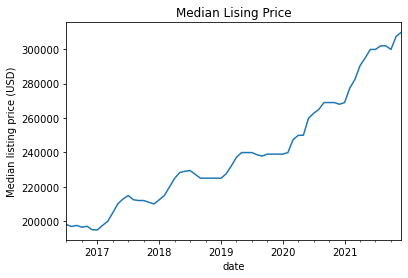

In [19]:
realtor_m.groupby(['date']).median()['median_listing_price'].plot()
plt.ylabel('Median listing price (USD)')
plt.title('Median Lising Price');

It show the strong upward trend over time and seasonality in listing price. 

In [20]:
realtor_m.groupby(['date']).median()['median_listing_price_per_square_foot'].plot()
plt.ylabel('Median listing price (USD)')
plt.title('Median Lising Price');

KeyError: 'median_listing_price_per_square_foot'

# EDA

### Housing price and housing sales within and outside of central business district 

In [ ]:
df_final[(df_final.cbd10==0) & (df_final.yearmonth>201601) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.cbd10==1) & (df_final.yearmonth>201601) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=1') 
plt.ylabel('Median listing price (USD)')
plt.legend()
plt.title('Median Listing Price: within 10KM of the city center vs outside');

In [ ]:
df_final[(df_final.cbd20==0) & (df_final.yearmonth>201601) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd20=0', figsize=(15,6)) 
df_final[(df_final.cbd20==1) & (df_final.yearmonth>201601) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd20=1') 
plt.ylabel('Median listing price (USD)')
plt.legend()
plt.title('Median Listing Price: Within 20KM of the city center vs Outside');

In [ ]:
df_final[(df_final.county_in_city==0) & (df_final.yearmonth>201601) ].groupby(['date']).median()['median_listing_price'].plot(label='county_in_city=0', figsize=(15,6)) 
df_final[(df_final.county_in_city==1) & (df_final.yearmonth>201601) ].groupby(['date']).median()['median_listing_price'].plot(label='county_in_city=1') 
plt.ylabel('Median listing price (USD)')
plt.legend()
plt.title('Median Listing Price: Within a city vs Outside');

- Historically, listing price between within 10 km of the central business district and outside has a significant sifferences (About 40,000USD). But the price gap has started shrinking since 2020 Summer, and the differences are almost zero by the end of 2021.  
- CBD10 will be the best feature to capture a price difference between city and suburb. 

In [ ]:
df_final[(df_final.cbd10==0) & (df_final.yearmonth>201710) ].groupby(['date']).median()['median_listing_price_yy'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.cbd10==1) & (df_final.yearmonth>201710) ].groupby(['date']).median()['median_listing_price_yy'].plot(label='cbd10=1') 
plt.ylabel('Median listing price (year-on-year change, USD)')
plt.legend()
plt.title('Median Listing Price (year-on-year change, USD)');

- Listing price outside of the central business district shows strong growth since 2020, while the price inside of the central business district had been stagnant since 2020 to early 2021.     

In [ ]:
df_final[(df_final.cbd10==0) & (df_final.yearmonth>201710) ].groupby(['date']).mean()['active_listing_count'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.cbd10==1) & (df_final.yearmonth>201710) ].groupby(['date']).mean()['active_listing_count'].plot(label='cbd10=1') 
plt.ylabel('Number of Active Listing')
plt.legend()
plt.title('Average number of active listings in a given zipcode');

- Number of active listing outside of the city center dropped shapely in 2020. It may refflect the surging demand for homes in outside of the city. 

In [ ]:
df_final[(df_final.cbd10==0) & (df_final.yearmonth>201710) ].groupby(['date']).mean()['median_days_on_market'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.cbd10==1) & (df_final.yearmonth>201710) ].groupby(['date']).mean()['median_days_on_market'].plot(label='cbd10=1') 
plt.ylabel('Numebr of Days on a market')
plt.legend()
plt.title('Median days on market per zipcode');

- Active listings and number of days on a market is a measurement of housing supply. Both figures tells that the housing supply is very tight (i.e., Supply shotage) in 2021. 

## Washington DC area 

In [ ]:
df_final[(df_final.czname=='Washington DC')&(df_final.cbd10==0) & (df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.czname=='Washington DC')&(df_final.cbd10==1) &(df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=1') 
plt.ylabel('Median Listing  price (USD)')
plt.legend()
plt.title('Median Listing  Price (USD)');

## San Francisco

In [ ]:
df_final[(df_final.czname=='San Francisco')&(df_final.cbd10==0) & (df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.czname=='San Francisco')&(df_final.cbd10==1) &(df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=1') 
plt.ylabel('Median Listing  price (USD)')
plt.legend()
plt.title('Median Listing  Price (USD)');

## Seattle

In [ ]:
df_final[(df_final.czname=='Seattle')&(df_final.cbd10==0) & (df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.czname=='Seattle')&(df_final.cbd10==1)&(df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=1') 
plt.ylabel('Median listing price (USD)')
plt.legend()
plt.title('Median Listing Price (USD)');

## New York City

In [ ]:
df_final[(df_final.czname=='New York City')&(df_final.cbd10==0) & (df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.czname=='New York City')&(df_final.cbd10==1)&(df_final.yearmonth>201801) ].groupby(['date']).median()['median_listing_price'].plot(label='cbd10=1') 
plt.ylabel('Median sales price (USD)')
plt.legend()
plt.title('Median Sales Price (USD)');

## Distance and Housing Price

In [ ]:
x1 = df_final[(df_final.yearmonth>202002) & (df_final.distance<100) & (df_final.median_listing_price < 10000000 )]['distance']
x2 = df_final[(df_final.yearmonth<=202002) & (df_final.distance<100) & (df_final.median_listing_price <10000000 )]['distance']
y1 = df_final[(df_final.yearmonth>202002) & (df_final.distance<100) & (df_final.median_listing_price < 10000000 )]['median_listing_price']
y2 = df_final[(df_final.yearmonth<=202002) & (df_final.distance<100) & (df_final.median_listing_price < 10000000 )]['median_listing_price']

plt.figure(figsize=(15,6))
plt.scatter(x2, y2, label='pre pandemic', alpha=0.6)
plt.scatter(x1, y1, label='pandemic', alpha=0.6)


plt.ylabel('Median sales price (USD)')
plt.legend()
plt.title('Median Sales Price (USD)');

In [ ]:
x1 = df_final[(df_final.yearmonth>202002) & (df_final.distance<100)]['distance']
x2 = df_final[(df_final.yearmonth<=202002) & (df_final.distance<100)]['distance']
y1 = df_final[(df_final.yearmonth>202002) & (df_final.distance<100)]['median_days_on_market']
y2 = df_final[(df_final.yearmonth<=202002) & (df_final.distance<100)]['median_days_on_market']

plt.figure(figsize=(15,6))
plt.scatter(x2, y2, label='pre pandemic', alpha=0.6)
plt.scatter(x1, y1, label='pandemic', alpha=0.6)


plt.ylabel('Number of days on market')
plt.legend()
plt.title('Median Number of Days on Market ');

### Washington DC

In [ ]:
import seaborn as sns

sns.regplot(x='distance', y='median_listing_price', 
            data=df_final[(df_final.yearmonth>202002) & (df_final.distance<100) & (df_final.czname=='Washington DC')], 
            label = 'Post Pandemic', line_kws={"color": "red"})
plt.title('2020 March -')
plt.figure(figsize=(15,6));


In [ ]:
sns.regplot(x='distance', y='median_listing_price', 
            data=df_final[(df_final.yearmonth<=202002) & (df_final.distance<100) & (df_final.czname=='Washington DC')], 
            label = 'Pre Pandemic', line_kws={"color": "red"})
plt.title('Pre COVID')
plt.figure(figsize=(15,6))

## Migration patterns

In [ ]:
df_final[(df_final.cbd10==0) & (df_final.yearmonth>201712) ].groupby(['date']).mean()['netinflow'].plot(label='cbd10=0', figsize=(15,6)) 
df_final[(df_final.cbd10==1) & (df_final.yearmonth>201712) ].groupby(['date']).mean()['netinflow'].plot(label='cbd10=1') 
plt.ylabel('Net inflow of people')
plt.legend()
plt.title('Net inflow of people');

### Washington DC, net inflow of people 

In [ ]:
df_final[(df_final.czname=='Washington DC')&(df_final.cbd10==0) & (df_final.yearmonth>201712) ].groupby(['date']).mean()['netinflow'].plot(label='cbd=0', figsize=(15,6)) 
df_final[(df_final.czname=='Washington DC')&(df_final.cbd10==1) & (df_final.yearmonth>201712) ].groupby(['date']).mean()['netinflow'].plot(label='cbd=1') 
plt.ylabel('Net inflow of people')
plt.legend()
plt.title('Net inflow of people in Washington DC');

Sharp drop in net inflow of people in center of the city in 2020 Supring to Summer

## Listing price and net inflow of people

In [ ]:
sns.regplot(x='netinflow', y='median_listing_price', 
            data=df_final[(df_final.median_listing_price<4000000)& (df_final.netinflow>-2000)], 
            line_kws={"color": "red"})
plt.title('Net Inflow and Listing Price')
plt.figure(figsize=(15,6))

## WFH and Migration

In [ ]:
x1 = df_final[(df_final.yearmonth>202003) ][ 'netinflow']
y1 = df_final[(df_final.yearmonth>202003) ]['wfh']

plt.figure(figsize=(15,6))
plt.scatter(x1, y1, alpha=0.6)

plt.xlabel('Net migration Inflow')
plt.ylabel('Work From Home compatability index')
plt.legend()
plt.title('Work from home index and migration');

In [ ]:
x1 = df_final[(df_final.yearmonth>202003)  & (df_final.median_listing_price_yy <1) &(df_final.czname=='Washington DC')]['wfh']
y1 = df_final[(df_final.yearmonth>202003) & (df_final.median_listing_price_yy <1) &(df_final.czname=='Washington DC')]['median_listing_price_yy']

plt.figure(figsize=(15,6))
plt.scatter(x1, y1, alpha=0.6)

plt.xlabel('Work From Home compatability index')
plt.ylabel('Listing Price, YoY Change')
plt.legend()
plt.title('Work from home index and Listing price');

In [ ]:
x1 = df_final[(df_final.yearmonth>202003)  & (df_final.median_listing_price_yy <1) & (df_final.distance <300) ]['distance']
y1 = df_final[(df_final.yearmonth>202003) & (df_final.median_listing_price_yy <1) & (df_final.distance <300)]['wfh']

plt.figure(figsize=(15,6))
plt.scatter(x1, y1, alpha=0.6, label=('post COVID'))

plt.xlabel('Distance from the cbeter of business district (KM)')
plt.ylabel('Work From Home compatability index')
plt.legend()
plt.title('Work from home index and distance');


In [ ]:
x1 = df_final[(df_final.czname=='Washington DC')&(df_final.yearmonth>202003)  & (df_final.median_listing_price_yy <1) ]['distance']
y1 = df_final[(df_final.czname=='Washington DC')&(df_final.yearmonth>202003) & (df_final.median_listing_price_yy <1) ]['wfh']

plt.figure(figsize=(15,6))
plt.scatter(x1, y1, alpha=0.6, label=('post COVID'))

plt.xlabel('Distance from the cbeter of business district (KM)')
plt.ylabel('Work From Home compatability index')
plt.legend()
plt.title('Work from home index and distance in Washington DC');
